<a href="https://colab.research.google.com/github/atharvanaik10/cs498-css/blob/main/cs498_rp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ydata-profiling
!pip install -q matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 22.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [19]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Creating the Dataset

This is a dataset of factors believed to influence homelessness across communities. The dictionary is included in the data folder in Google Drive.

Tasks
1. Find dataset for all counties
2. Write a script based on API calls for each county to download the excel sheets for 2010-2017

Source: https://www.huduser.gov/portal/datasets/hpmd.html?q=datasets%2Fhpmd.html

In [20]:
data_filepath = 'https://raw.githubusercontent.com/atharvanaik10/cs498-css/main/data/05b_analysis_file_update.csv'
df_full = pd.read_csv(data_filepath)

df_il = df_full[df_full['cocnumber'].str.contains('IL')]
df_il['pit_tot_pit_hud'] = (df_il['pit_tot_shelt_pit_hud'] + df_il['pit_tot_unshelt_pit_hud'] + df_il['pit_tot_hless_pit_hud'])
df_il

<ipython-input-20-57652406b205>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_il['pit_tot_pit_hud'] = (df_il['pit_tot_shelt_pit_hud'] + df_il['pit_tot_unshelt_pit_hud'] + df_il['pit_tot_hless_pit_hud'])


,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,sub_high_cost_homeval75,sub_high_rent_share75,tight_high_cost_rental_mkt,sub_tight_high_cost_rent,sub_west_coast_all_urb,sub_west_census,major_city,suburban,rural,pit_tot_pit_hud
840,2010,IL-500,211.0,1.0,212.0,123.0,1.0,124.0,88.0,0.0,...,1,1,3,1,0,0,0,1,0,424.0
841,2011,IL-500,179.0,3.0,182.0,110.0,3.0,113.0,69.0,0.0,...,0,0,0,0,0,0,0,1,0,364.0
842,2012,IL-500,193.0,3.0,196.0,120.0,3.0,123.0,73.0,0.0,...,1,1,3,1,0,0,0,1,0,392.0
843,2013,IL-500,180.0,5.0,185.0,106.0,5.0,111.0,74.0,0.0,...,0,0,0,0,0,0,0,1,0,370.0
844,2014,IL-500,161.0,5.0,166.0,103.0,5.0,108.0,58.0,0.0,...,1,1,3,1,0,0,0,1,0,332.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,2013,IL-520,263.0,75.0,338.0,121.0,39.0,160.0,142.0,36.0,...,0,0,0,0,0,0,0,0,1,676.0
988,2014,IL-520,279.0,46.0,325.0,142.0,33.0,175.0,137.0,13.0,...,1,1,3,1,0,0,0,0,1,650.0
989,2015,IL-520,316.0,30.0,346.0,166.0,26.0,192.0,150.0,4.0,...,0,0,0,0,0,0,0,0,1,692.0
990,2016,IL-520,332.0,19.0,351.0,159.0,16.0,175.0,173.0,3.0,...,1,1,3,1,0,0,0,0,1,702.0


Since this dataset does not contain any health/healthcare data, we append a health dataset from Illinois below.

The first step is to create a master health rankings dataset for all the counties in Illinois for all the years.

In [21]:
# Load yearly datasets
years = range(2010, 2018)
file_path_template = 'https://raw.githubusercontent.com/atharvanaik10/cs498-css/main/data/health_data/{}_county_ranking.xls'# Assuming the files are named like 'health_data_2010.xlsx', etc.

# Initialize an empty list to store each year's DataFrame
health_dfs = []

for year in years:
    file_path = file_path_template.format(year)
    # Load the "Subrankings" sheet from the current year's file
    df = pd.read_excel(file_path, sheet_name='Outcomes & Factors SubRankings', header=[0,1])
    # Create new column names by combining the top-level category with the subcolumn name
    df.columns = [f'{col[0]}_{col[1]}'.replace(' ', '_') if col[1] else col[0].replace(' ', '_') for col in df.columns]
    # Add a 'year' column to the DataFrame
    df['year'] = year
    # Append the DataFrame to the list
    health_dfs.append(df)

In [22]:
# Combine into master health ranking dataset and drop irrelevant columns
df_health_rankings = pd.concat(health_dfs, ignore_index=True)
df_health_rankings.drop(0, axis='index', inplace=True)
df_health_rankings.drop(['Unnamed:_0_level_0_FIPS', 'Unnamed:_1_level_0_State'], axis=1, inplace=True)
df_health_rankings.rename(columns={'Unnamed:_2_level_0_County' : 'county'}, inplace=True)

# We note that the "Mortality" column was changed to "Length of Life" and
# the "Morbidity" column was changed to "Quality of Life". Hence, we combine
# these two columns into one.
df_health_rankings['Mortality_Z-Score'] = df_health_rankings['Mortality_Z-Score'].combine_first(df_health_rankings['Length_of_Life_Z-Score'])
df_health_rankings['Mortality_Rank'] = df_health_rankings['Mortality_Rank'].combine_first(df_health_rankings['Length_of_Life_Rank'])
df_health_rankings['Morbidity_Z-Score'] = df_health_rankings['Morbidity_Z-Score'].combine_first(df_health_rankings['Quality_of_Life_Z-Score'])
df_health_rankings['Morbidity_Rank'] = df_health_rankings['Morbidity_Rank'].combine_first(df_health_rankings['Quality_of_Life_Rank'])
df_health_rankings.drop(['Length_of_Life_Z-Score', 'Length_of_Life_Rank', 'Quality_of_Life_Z-Score', 'Quality_of_Life_Rank'], axis=1, inplace=True)

df_health_rankings

,county,Mortality_Z-Score,Mortality_Rank,Morbidity_Z-Score,Morbidity_Rank,Health_Behaviors_Z-Score,Health_Behaviors_Rank,Clinical_Care_Z-Score,Clinical_Care_Rank,Social_&_Economic_Factors_Z-Score,Social_&_Economic_Factors_Rank,Physical_Environment_Z-Score,Physical_Environment_Rank,year
1,Adams,-0.315922,26.0,0.018905,55.0,-0.177479,9.0,-0.128418,8.0,-0.222109,18.0,-0.003727,53.0,2010
2,Alexander,1.449328,99.0,0.600000,100.0,0.324788,99.0,-0.132972,6.0,0.814184,101.0,0.070877,94.0,2010
3,Bond,-0.218783,36.0,0.296697,81.0,0.062052,74.0,0.005012,60.0,-0.082260,42.0,-0.046851,13.0,2010
4,Boone,-0.539522,11.0,0.075576,63.0,-0.248704,4.0,0.005551,61.0,0.242444,82.0,-0.005828,50.0,2010
5,Brown,-0.282644,30.0,-0.197342,27.0,0.073038,80.0,-0.052093,36.0,-0.222639,16.0,-0.067829,2.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Whiteside,-0.101659,44.0,-0.395511,15.0,-0.095026,24.0,-0.070668,27.0,-0.037313,44.0,-0.024960,40.0,2017
820,Will,-0.700882,8.0,-0.180036,37.0,-0.150657,11.0,-0.022934,38.0,-0.234465,17.0,0.102365,98.0,2017
821,Williamson,0.323895,81.0,0.073420,60.0,0.093817,78.0,-0.005888,45.0,0.076363,69.0,0.015021,67.0,2017
822,Winnebago,0.247607,73.0,0.421506,91.0,0.210368,96.0,-0.001822,48.0,0.409720,96.0,0.060289,90.0,2017


Now we have two datasets, one for homelessness and other economic factors that is split by CoC, and one for health rankings that is split by county. Thankfully in most cases, CoC boundaries map neatly to existing county boundaries. We create a CoC to county mapping below and merge our datasets into a master dataset that is separated by CoC that includes the average health factors of all the counties in that CoC.

In [23]:
coc_to_county = {
    'IL-500' : ['McHenry'],
    'IL-501' : ['Winnebago', 'Boone'],
    'IL-502' : ['Lake'],
    'IL-503' : ['Champaign'],
    'IL-504' : ['Madison'],
    'IL-506' : ['Will', 'Kendall', 'Grundy'],
    'IL-507' : ['Peoria', 'Fulton', 'Tazewell', 'Woodford'],
    'IL-508' : ['McHenry'],
    'IL-509' : ['DeKalb'],
    'IL-510' : ['Cook'],
    'IL-511' : ['Cook'],
    'IL-512' : ['DeWitt', 'Ford', 'Iroquois', 'Kankakee', 'Livingston', 'Logan',
                'Mason', 'Menard', 'McLean', 'Piatt', 'Vermilion'],
    'IL-513' : ['Sangamon'],
    'IL-514' : ['DuPage'],
    'IL-515' : ['Calhoun', 'Christian', 'Clark', 'Clay', 'Coles', 'Crawford',
                'Cumberland', 'Douglas', 'Edgar', 'Effingham', 'Fayette',
                'Greene', 'Jasper', 'Jersey', 'Macoupin', 'Montgomery',
                'Moultrie', 'Shelby'],
    'IL-516' : ['Macon'],
    'IL-517' : ['Kane'],
    'IL-518' : ['Bureau', 'Carroll', 'Jo Daviess', 'Henry', 'Knox', 'LaSalle',
                'Lee', 'Marshall', 'Mercer', 'Ogle', 'Putnam', 'Rock Island',
                'Stark', 'Stephenson', 'Whiteside'],
    'IL-519' : ['Adams', 'Brown', 'Cass', 'Hancock', 'Henderson', 'McDonough',
                'Morgan', 'Pike', 'Schuyler', 'Scott', 'Warren'],
    'IL-520' : ['Alexander', 'Bond', 'Clinton', 'Edwards', 'Franklin',
                'Gallatin', 'Hamilton', 'Hardin', 'Jackson', 'Jefferson',
                'Johnson', 'Lawrence', 'Marion', 'Massac', 'Monroe', 'Perry',
                'Pope', 'Pulaski', 'Randolph', 'Richland', 'Saline', 'Union',
                'Wabash', 'Washington', 'Wayne', 'White', 'Williamson'],
}

In [24]:
# Calculate mean stats by CoC
coc_avgs = []
for coc, counties in coc_to_county.items():
  subset = df_health_rankings[df_health_rankings['county'].isin(counties)]
  avg_stats = subset.groupby('year').mean(numeric_only=True).reset_index()
  avg_stats['cocnumber'] = coc
  coc_avgs.append(avg_stats)

# combine all averages
coc_avg_df = pd.concat(coc_avgs, ignore_index=True)

df = pd.merge(df_il, coc_avg_df, on=['cocnumber', 'year'], how='left')
df

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,Morbidity_Z-Score,Morbidity_Rank,Health_Behaviors_Z-Score,Health_Behaviors_Rank,Clinical_Care_Z-Score,Clinical_Care_Rank,Social_&_Economic_Factors_Z-Score,Social_&_Economic_Factors_Rank,Physical_Environment_Z-Score,Physical_Environment_Rank
0,2010,IL-500,211.0,1.0,212.0,123.0,1.0,124.0,88.0,0.0,...,-0.262275,19.000000,-0.077647,29.000000,-0.065311,27.000000,-0.431845,5.000000,0.009561,70.000000
1,2011,IL-500,179.0,3.0,182.0,110.0,3.0,113.0,69.0,0.0,...,-0.319520,16.000000,-0.116947,16.000000,-0.011183,50.000000,-0.368764,7.000000,-0.050696,11.000000
2,2012,IL-500,193.0,3.0,196.0,120.0,3.0,123.0,73.0,0.0,...,-0.274948,20.000000,-0.264598,4.000000,-0.067671,29.000000,-0.398543,7.000000,0.002239,60.000000
3,2013,IL-500,180.0,5.0,185.0,106.0,5.0,111.0,74.0,0.0,...,-0.097183,42.000000,-0.245293,5.000000,-0.115609,17.000000,-0.356753,7.000000,-0.023845,25.000000
4,2014,IL-500,161.0,5.0,166.0,103.0,5.0,108.0,58.0,0.0,...,-0.137073,35.000000,-0.199592,6.000000,-0.091232,23.000000,-0.412663,6.000000,0.063221,97.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2013,IL-520,263.0,75.0,338.0,121.0,39.0,160.0,142.0,36.0,...,0.123743,62.481481,0.037166,61.037037,0.051943,66.259259,0.108449,64.962963,0.033150,72.925926
148,2014,IL-520,279.0,46.0,325.0,142.0,33.0,175.0,137.0,13.0,...,0.136255,65.777778,0.053163,63.074074,0.060579,66.814815,0.102835,63.222222,0.020539,67.703704
149,2015,IL-520,316.0,30.0,346.0,166.0,26.0,192.0,150.0,4.0,...,0.157189,67.777778,0.061233,66.370370,0.068371,69.518519,0.111391,66.000000,0.022888,67.814815
150,2016,IL-520,332.0,19.0,351.0,159.0,16.0,175.0,173.0,3.0,...,0.211328,67.185185,0.083181,67.925926,0.065990,70.370370,0.110339,64.185185,0.013939,60.222222


# Data Exploration

### Using `ydata-profiling`

In [ ]:
profile = ProfileReport(df, title="Time-series Report", tsmode=True, sortby='year')
profile.to_file("df_report.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/pandas/describe_timeseries_pandas.py:95: RuntimeWarning: divide by zero encountered in log10
  ampl = 10 * np.log10(data_psd[pos_freq_ix])
/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'IL-500'')
  warnings.warn(


### Manual exploration

Text(0.5, 1.0, 'Ratio of Sheltered Population per CoC')

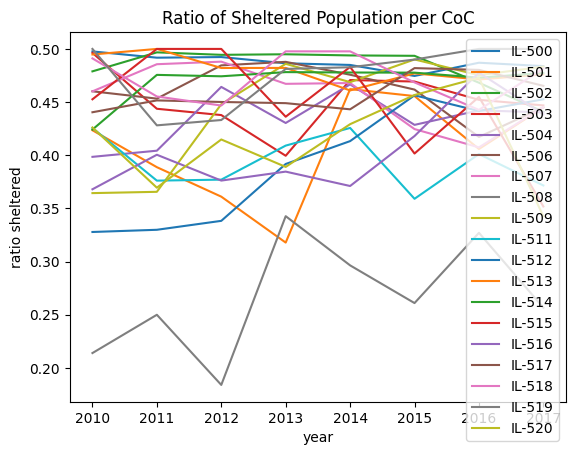

In [ ]:
coc_numbers = ['IL-500',
 'IL-501',
 'IL-502',
 'IL-503',
 'IL-504',
 'IL-506',
 'IL-507',
 'IL-508',
 'IL-509',
 'IL-511',
 'IL-512',
 'IL-513',
 'IL-514',
 'IL-515',
 'IL-516',
 'IL-517',
 'IL-518',
 'IL-519',
 'IL-520']

# data visualization for the total sheltered population per county in Illinois
for i in range(len(coc_numbers)):
  df_co = df_il[df_il['cocnumber']== coc_numbers[i]]
  plt.plot(df_co['year'],df_co['pit_tot_shelt_pit_hud'] / df_co['pit_tot_pit_hud'])
plt.legend(coc_numbers);
plt.ylabel('ratio sheltered')
plt.xlabel('year')
plt.title('Ratio of Sheltered Population per CoC')

Text(0.5, 1.0, 'Ratio of Unsheltered Population per CoC')

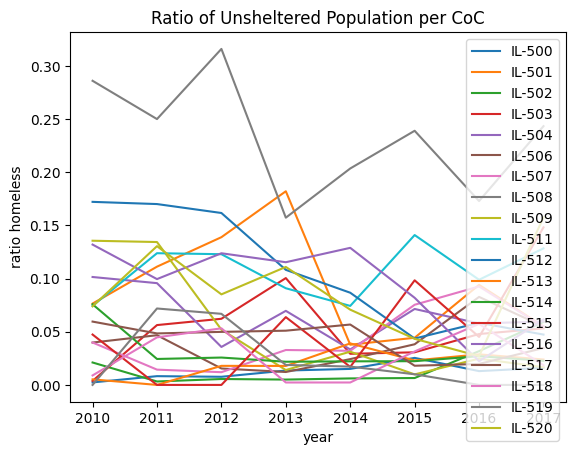

In [ ]:
# data visualization of the ratio of total population that is unsheltered per county in Illinois
for i in range(len(coc_numbers)):
  df_co = df_il[df_il['cocnumber']== coc_numbers[i]]
  plt.plot(df_co['year'],df_co['pit_tot_unshelt_pit_hud'] / df_co['pit_tot_pit_hud'])
plt.legend(coc_numbers);
plt.ylabel('ratio homeless')
plt.xlabel('year')
plt.title('Ratio of Unsheltered Population per CoC')

Text(0.5, 1.0, 'Ratio of Homeless Population per CoC')

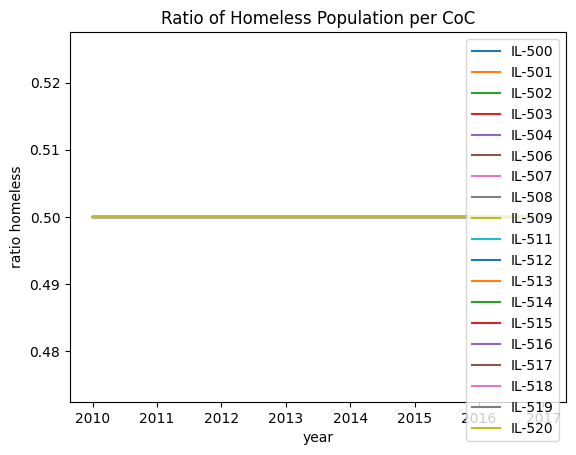

In [ ]:
# data visualization of the ratio of total population that is homeless per county in Illinois
for i in range(len(coc_numbers)):
  df_co = df_il[df_il['cocnumber']== coc_numbers[i]]
  plt.plot(df_co['year'],df_co['pit_tot_hless_pit_hud'] / df_co['pit_tot_pit_hud'])
plt.legend(coc_numbers);
plt.ylabel('ratio homeless')
plt.xlabel('year')
plt.title('Ratio of Homeless Population per CoC')

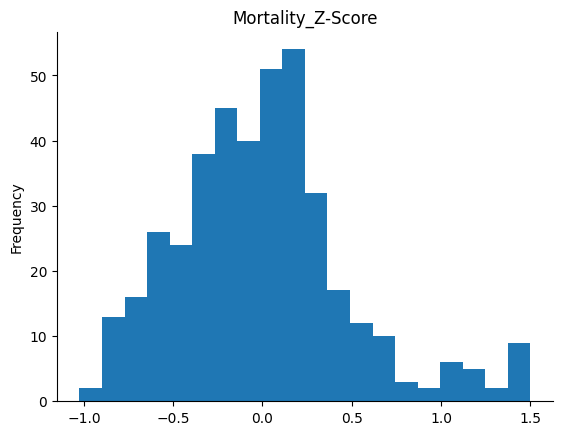

In [ ]:
# @title Mortality_Z-Score

from matplotlib import pyplot as plt
df_health_rankings['Mortality_Z-Score'].plot(kind='hist', bins=20, title='Mortality_Z-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

Text(0.5, 1.0, 'Mortality_Z-Score vs Mortality_Rank')

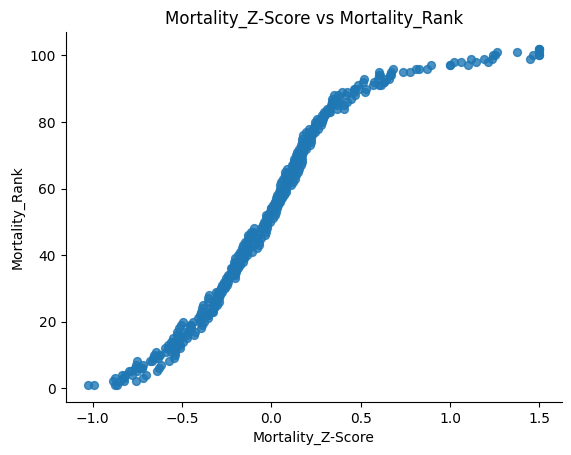

In [ ]:
# @title Mortality_Z-Score vs Mortality_Rank

from matplotlib import pyplot as plt
df_health_rankings.plot(kind='scatter', x='Mortality_Z-Score', y='Mortality_Rank', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title("Mortality_Z-Score vs Mortality_Rank")

Now that we have the master dataset, we create a mapping from counties to CoCs and append by average ranking and average z-score by the counties in each CoC. (TODO).

# Correlation Analysis

In [48]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Replace NaN values with 0
df.fillna(0, inplace=True)
df

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,Morbidity_Z-Score,Morbidity_Rank,Health_Behaviors_Z-Score,Health_Behaviors_Rank,Clinical_Care_Z-Score,Clinical_Care_Rank,Social_&_Economic_Factors_Z-Score,Social_&_Economic_Factors_Rank,Physical_Environment_Z-Score,Physical_Environment_Rank
0,2010,IL-500,211.0,1.0,212.0,123.0,1.0,124.0,88.0,0.0,...,-0.262275,19.000000,-0.077647,29.000000,-0.065311,27.000000,-0.431845,5.000000,0.009561,70.000000
1,2011,IL-500,179.0,3.0,182.0,110.0,3.0,113.0,69.0,0.0,...,-0.319520,16.000000,-0.116947,16.000000,-0.011183,50.000000,-0.368764,7.000000,-0.050696,11.000000
2,2012,IL-500,193.0,3.0,196.0,120.0,3.0,123.0,73.0,0.0,...,-0.274948,20.000000,-0.264598,4.000000,-0.067671,29.000000,-0.398543,7.000000,0.002239,60.000000
3,2013,IL-500,180.0,5.0,185.0,106.0,5.0,111.0,74.0,0.0,...,-0.097183,42.000000,-0.245293,5.000000,-0.115609,17.000000,-0.356753,7.000000,-0.023845,25.000000
4,2014,IL-500,161.0,5.0,166.0,103.0,5.0,108.0,58.0,0.0,...,-0.137073,35.000000,-0.199592,6.000000,-0.091232,23.000000,-0.412663,6.000000,0.063221,97.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2013,IL-520,263.0,75.0,338.0,121.0,39.0,160.0,142.0,36.0,...,0.123743,62.481481,0.037166,61.037037,0.051943,66.259259,0.108449,64.962963,0.033150,72.925926
148,2014,IL-520,279.0,46.0,325.0,142.0,33.0,175.0,137.0,13.0,...,0.136255,65.777778,0.053163,63.074074,0.060579,66.814815,0.102835,63.222222,0.020539,67.703704
149,2015,IL-520,316.0,30.0,346.0,166.0,26.0,192.0,150.0,4.0,...,0.157189,67.777778,0.061233,66.370370,0.068371,69.518519,0.111391,66.000000,0.022888,67.814815
150,2016,IL-520,332.0,19.0,351.0,159.0,16.0,175.0,173.0,3.0,...,0.211328,67.185185,0.083181,67.925926,0.065990,70.370370,0.110339,64.185185,0.013939,60.222222


In [27]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Extract numeric data
numeric_data = df[numeric_columns]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform only the numeric data
scaled_data_numeric = scaler.fit_transform(numeric_data)

# Replace the scaled numeric values back into the original DataFrame
df[numeric_columns] = scaled_data_numeric
df

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,Morbidity_Z-Score,Morbidity_Rank,Health_Behaviors_Z-Score,Health_Behaviors_Rank,Clinical_Care_Z-Score,Clinical_Care_Rank,Social_&_Economic_Factors_Z-Score,Social_&_Economic_Factors_Rank,Physical_Environment_Z-Score,Physical_Environment_Rank
0,-1.527525,IL-500,-0.281399,-0.341225,-0.297729,-0.261507,-0.307872,-0.280874,-0.301240,-0.499818,...,-1.006607,-1.312246,-0.009642,-0.360627,-0.019283,-0.381240,-1.498101,-1.352668,-0.175164,0.307714
1,-1.091089,IL-500,-0.306863,-0.335668,-0.316476,-0.281342,-0.302182,-0.291923,-0.332647,-0.499818,...,-1.242296,-1.437779,-0.229357,-0.810540,0.526482,0.556672,-1.230978,-1.281018,-1.292698,-1.917276
2,-0.654654,IL-500,-0.295723,-0.335668,-0.307727,-0.266084,-0.302182,-0.281878,-0.326035,-0.499818,...,-1.058785,-1.270402,-1.054822,-1.225845,-0.043076,-0.299682,-1.357079,-1.281018,-0.310959,-0.069403
3,-0.218218,IL-500,-0.306067,-0.330112,-0.314601,-0.287445,-0.296493,-0.293932,-0.324382,-0.499818,...,-0.326895,-0.349824,-0.946895,-1.191237,-0.526421,-0.789027,-1.180115,-1.281018,-0.794720,-1.389313
4,0.218218,IL-500,-0.321186,-0.330112,-0.326474,-0.292022,-0.296493,-0.296946,-0.350831,-0.499818,...,-0.491127,-0.642735,-0.691395,-1.156628,-0.280637,-0.544355,-1.416874,-1.316843,0.820037,1.325929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-0.218218,IL-520,-0.240021,-0.135638,-0.218994,-0.264558,-0.199770,-0.244712,-0.211977,0.732720,...,0.582703,0.507212,0.632234,0.748135,1.162958,1.219704,0.789832,0.795510,0.262339,0.418055
148,0.218218,IL-520,-0.227289,-0.216206,-0.227117,-0.232517,-0.216839,-0.229645,-0.220242,-0.054734,...,0.634213,0.645144,0.721666,0.818634,1.250039,1.242359,0.766059,0.733148,0.028442,0.221116
149,0.654654,IL-520,-0.197846,-0.260657,-0.213995,-0.195899,-0.236752,-0.212569,-0.198753,-0.362869,...,0.720404,0.728833,0.766782,0.932715,1.328600,1.352612,0.802289,0.832662,0.072003,0.225307
150,1.091089,IL-520,-0.185115,-0.291217,-0.210870,-0.206579,-0.265200,-0.229645,-0.160734,-0.397106,...,0.943306,0.704036,0.889491,0.986551,1.304590,1.387350,0.797835,0.767646,-0.093962,-0.061023


In [36]:
# Perform PCA
pca = PCA(n_components=4)
pca.fit(scaled_data_numeric)

PCA(n_components=4)

Explained Variance Ratio: [0.22176337 0.14667538 0.13841475 0.08860591]
Cumulative Explained Variance: [0.22176337 0.36843875 0.5068535  0.59545942]
Number of components to retain: 4


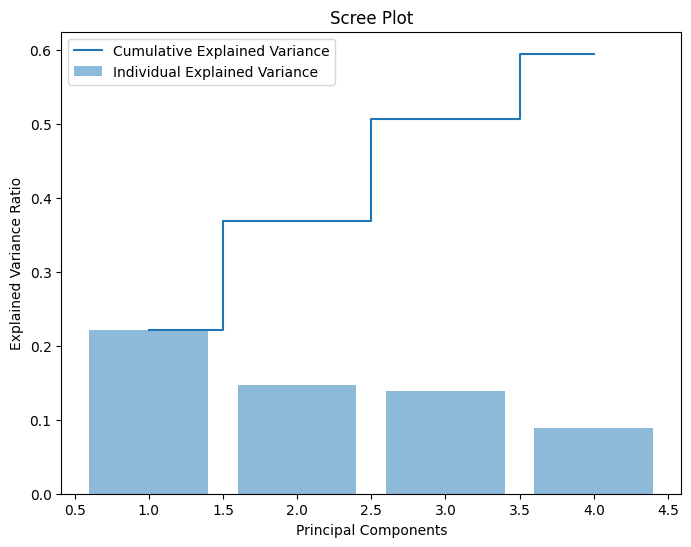

In [37]:
# display PCA

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

# Determine the number of components to retain
n_components = len(cumulative_variance[cumulative_variance <= 0.95])
print("Number of components to retain:", n_components)

# Apply dimensionality reduction
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(scaled_data_numeric)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=pca_data, columns=[f"PC{i+1}" for i in range(n_components)])

# Concatenate original DataFrame with PCA DataFrame if needed
# pca_df = pd.concat([df, pca_df], axis=1)

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.5, align='center', label='Individual Explained Variance')
plt.step(range(1, n_components + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.show()

In [42]:
# get component list

# Get the principal component vectors
components = pca.components_


# Create a DataFrame to display the component loadings
component_loadings = pd.DataFrame(components, columns=df[numeric_columns].columns)

# Display the component loadings
print("Component Loadings:")
print(component_loadings)

Component Loadings:
       year  pit_tot_shelt_pit_hud  pit_tot_unshelt_pit_hud  \
0  0.006631               0.109570                 0.105316   
1  0.075076              -0.025715                -0.018534   
2  0.013078               0.040716                 0.051280   
3 -0.005463               0.002600                 0.000447   

   pit_tot_hless_pit_hud  pit_ind_shelt_pit_hud  pit_ind_unshelt_pit_hud  \
0               0.109733               0.110408                 0.106542   
1              -0.024363              -0.023734                -0.017581   
2               0.043508               0.040061                 0.048960   
3               0.002143               0.001053                -0.000268   

   pit_ind_hless_pit_hud  pit_perfam_shelt_pit_hud  \
0               0.110308                  0.107996   
1              -0.021833                 -0.027706   
2               0.043662                  0.041179   
3               0.000598                  0.004261   

   pit_perfa

In [45]:
# another way to print
# Print loadings for each component
count = 0
for i, component in enumerate(df[numeric_columns].iterrows(), 1):
    count +=1
    print(f"Principal Component {i} Loadings:")
    print(component[1])
    print()  # for better readability
    if(count > 5):
      break

Principal Component 1 Loadings:
year                                -1.527525
pit_tot_shelt_pit_hud               -0.281399
pit_tot_unshelt_pit_hud             -0.341225
pit_tot_hless_pit_hud               -0.297729
pit_ind_shelt_pit_hud               -0.261507
                                       ...   
Clinical_Care_Rank                  -0.381240
Social_&_Economic_Factors_Z-Score   -1.498101
Social_&_Economic_Factors_Rank      -1.352668
Physical_Environment_Z-Score        -0.175164
Physical_Environment_Rank            0.307714
Name: 0, Length: 343, dtype: float64

Principal Component 2 Loadings:
year                                -1.091089
pit_tot_shelt_pit_hud               -0.306863
pit_tot_unshelt_pit_hud             -0.335668
pit_tot_hless_pit_hud               -0.316476
pit_ind_shelt_pit_hud               -0.281342
                                       ...   
Clinical_Care_Rank                   0.556672
Social_&_Economic_Factors_Z-Score   -1.230978
Social_&_Economic_Factor

# Correlation Matrix

In [47]:
# Compute pairwise correlation of columns
correlation_matrix = df[numeric_columns].corr()

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                                       year  pit_tot_shelt_pit_hud  \
year                               1.000000              -0.039198   
pit_tot_shelt_pit_hud             -0.039198               1.000000   
pit_tot_unshelt_pit_hud           -0.024653               0.941887   
pit_tot_hless_pit_hud             -0.036327               0.997141   
pit_ind_shelt_pit_hud             -0.022614               0.997307   
...                                     ...                    ...   
Clinical_Care_Rank                -0.035471               0.315227   
Social_&_Economic_Factors_Z-Score  0.010636               0.321069   
Social_&_Economic_Factors_Rank    -0.009115               0.364997   
Physical_Environment_Z-Score       0.105139               0.288881   
Physical_Environment_Rank          0.135905               0.148170   

                                   pit_tot_unshelt_pit_hud  \
year                                             -0.024653   
pit_tot_shelt_p

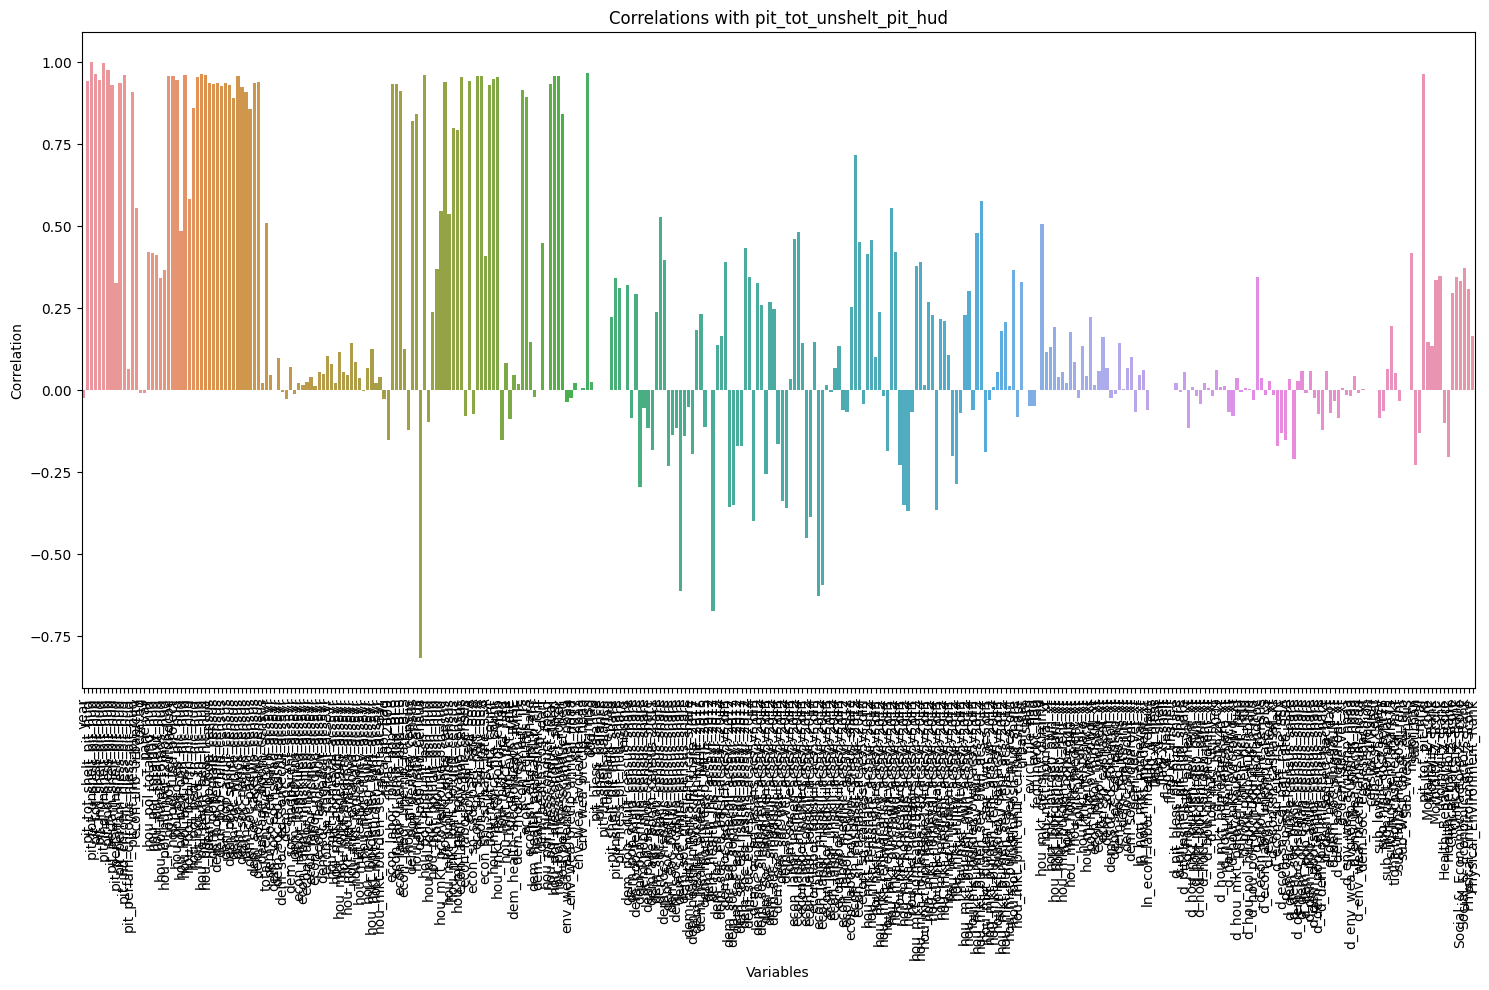

In [55]:
# use a single column (unsheltered)
specific_column = 'pit_tot_unshelt_pit_hud'  # Replace 'column_name' with the name of your specific column
correlations_with_specific_column = correlation_matrix[specific_column]

plt.figure(figsize=(15, 10))
sns.barplot(x=correlations_with_specific_column.index, y=correlations_with_specific_column.values)
plt.title(f'Correlations with {specific_column}')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()





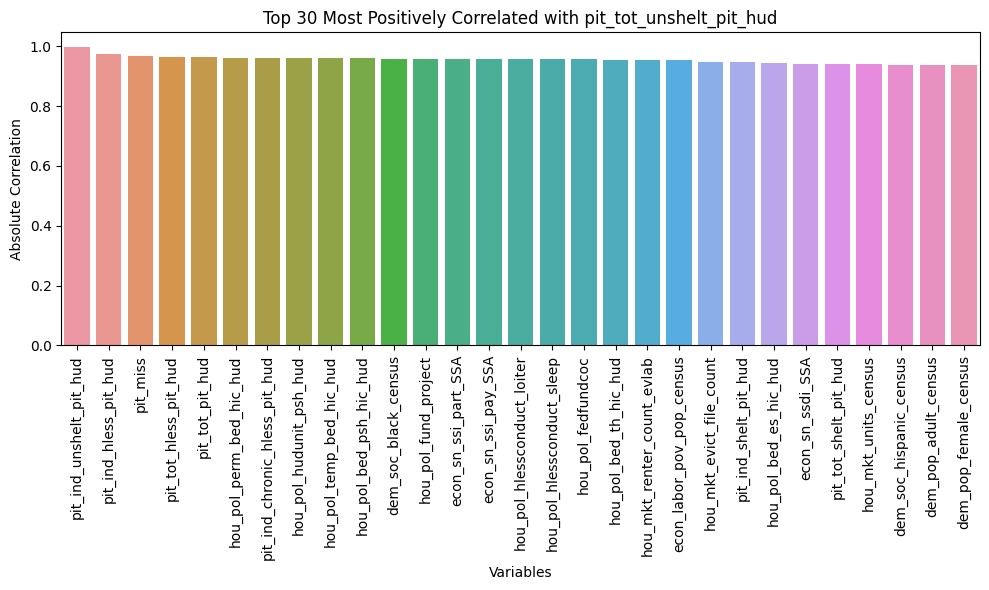

In [59]:
top_pos_correlations = correlations_with_specific_column.sort_values(ascending=False).head(30)

# Remove the correlation of the specific column with itself
top_pos_correlations = top_pos_correlations[top_pos_correlations.index != specific_column]
plt.figure(figsize=(10, 6))
sns.barplot(x=top_pos_correlations.index, y=top_pos_correlations.values)
plt.title(f'Top 30 Most Positively Correlated with {specific_column}')
plt.xlabel('Variables')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


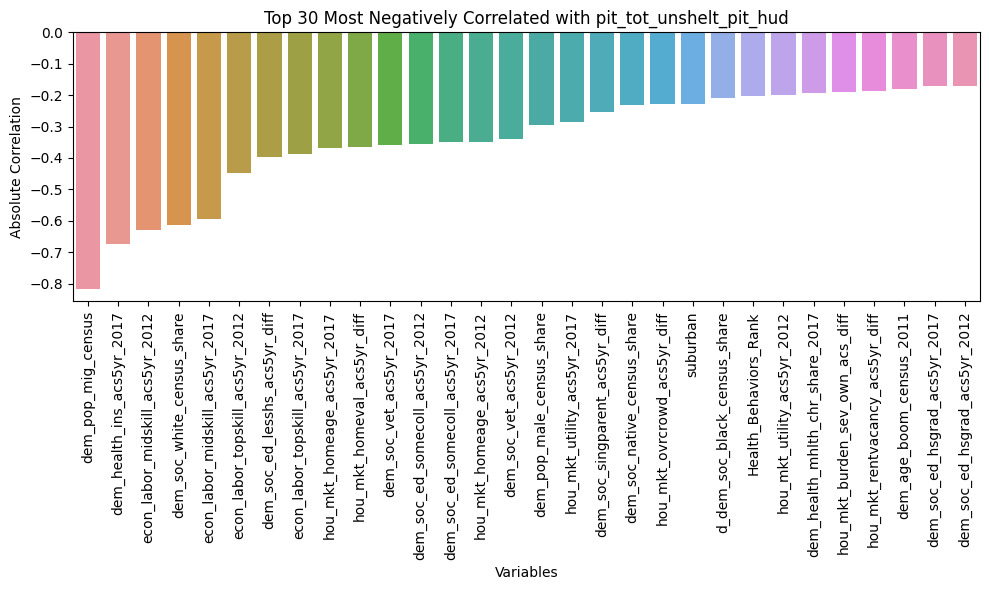

In [60]:
top_neg_correlations = correlations_with_specific_column.sort_values(ascending=True).head(30)

# Remove the correlation of the specific column with itself
top_neg_correlations = top_neg_correlations[top_neg_correlations.index != specific_column]
plt.figure(figsize=(10, 6))
sns.barplot(x=top_neg_correlations.index, y=top_neg_correlations.values)
plt.title(f'Top 30 Most Negatively Correlated with {specific_column}')
plt.xlabel('Variables')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(correlations_with_specific_column, annot=True, cmap='coolwarm', fmt=".2f")

# Add title and rotate tick labels
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show plot
plt.show()